# Лабораторная работа №5.1

### Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, model_selection, linear_model, tree, metrics
from sklearn.pipeline import Pipeline
import warnings

# Отключение предупреждений
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

### Загрузка данных

In [3]:
def load_diabetes_data():
    """Загрузка датасета диабета"""
    # Используем локальную загрузку (альтернативный способ)
    try:
        data = pd.read_csv('diabetes.csv')
    except:
        # Если файл не найден локально, скачиваем
        import urllib.request
        url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
        column_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
                       'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
        data = pd.read_csv(url, names=column_names)
    return data

# Загрузка данных
diabetes_df = load_diabetes_data()
print(f"Размер датасета: {diabetes_df.shape}")
print("\nПервые 5 строк:")
print(diabetes_df.head())

Размер датасета: (768, 9)

Первые 5 строк:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [4]:
print("\nИнформация о данных:")
print(diabetes_df.info())
print("\nРаспределение классов Outcome:")
print(diabetes_df['Outcome'].value_counts())


Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

Распределение классов Outcome:
Outcome
0    500
1    268
Name: count, dtype: int64


### Подготовка данных

In [5]:
features = diabetes_df.drop('Outcome', axis=1)
target = diabetes_df['Outcome']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    features, target, 
    test_size=0.2, 
    random_state=123,
    stratify=target  # Сохранение пропорций классов
)

print(f"\nРазмеры выборок:")
print(f"Обучающая: {X_train.shape}, Тестовая: {X_test.shape}")


Размеры выборок:
Обучающая: (614, 8), Тестовая: (154, 8)


### Модели классификации

In [6]:
# 1. Логистическая регрессия с пайплайном
logistic_pipeline = Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('classifier', linear_model.LogisticRegression(
        max_iter=1500,
        random_state=123,
        class_weight='balanced'
    ))
])

# 2. Решающее дерево
decision_tree = tree.DecisionTreeClassifier(
    random_state=123,
    class_weight='balanced'
)

# Обучение моделей
logistic_pipeline.fit(X_train, y_train)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=123)

### Оценка моделей

In [9]:
def calculate_metrics(model, X_data, y_data, model_name):
    """Вычисление метрик для модели"""
    predictions = model.predict(X_data)
    
    # Для получения вероятностей (нужно для ROC-AUC)
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(X_data)[:, 1]
        roc_auc = metrics.roc_auc_score(y_data, probabilities)
    else:
        roc_auc = None
    
    metrics_dict = {
        'Модель': model_name,
        'Точность (Accuracy)': metrics.accuracy_score(y_data, predictions),
        'Точность (Precision)': metrics.precision_score(y_data, predictions),
        'Полнота (Recall)': metrics.recall_score(y_data, predictions),
        'F1-мера': metrics.f1_score(y_data, predictions),
        'ROC-AUC': roc_auc
    }
    
    return metrics_dict, predictions

# Вычисление метрик для обеих моделей
logistic_metrics, logistic_preds = calculate_metrics(
    logistic_pipeline, X_test, y_test, "Логистическая регрессия"
)

tree_metrics, tree_preds = calculate_metrics(
    decision_tree, X_test, y_test, "Решающее дерево"
)

# Создание таблицы сравнения
comparison_df = pd.DataFrame([logistic_metrics, tree_metrics])
print(comparison_df.round(4).to_string(index=False))


                 Модель  Точность (Accuracy)  Точность (Precision)  Полнота (Recall)  F1-мера  ROC-AUC
Логистическая регрессия               0.7987                0.7091            0.7222   0.7156   0.8709
        Решающее дерево               0.7662                0.6552            0.7037   0.6786   0.7519


### Иследование глубины дерева

Оптимальная глубина по ROC-AUC: 3
Максимальный ROC-AUC: 0.8173
Оптимальная глубина по Accuracy: 5
Максимальный Accuracy: 0.7792


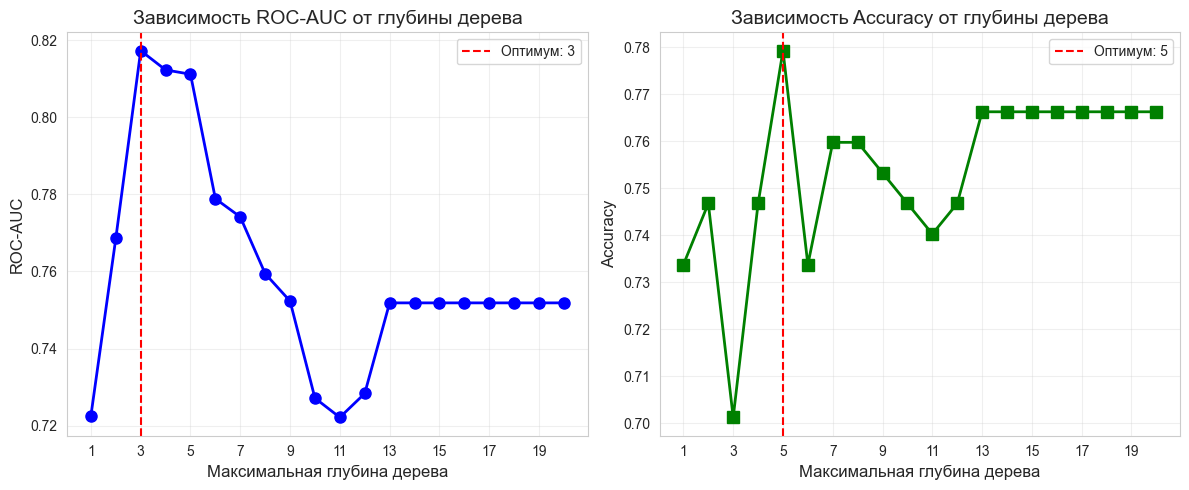

In [11]:
# Исследование глубины дерева с использованием ROC-AUC
depths_range = list(range(1, 21))
roc_auc_values = []
accuracy_values = []

for depth_val in depths_range:
    temp_tree = tree.DecisionTreeClassifier(
        max_depth=depth_val,
        random_state=123,
        class_weight='balanced'
    )
    temp_tree.fit(X_train, y_train)
    
    # Прогноз вероятностей для ROC-AUC
    y_proba = temp_tree.predict_proba(X_test)[:, 1]
    roc_auc = metrics.roc_auc_score(y_test, y_proba)
    roc_auc_values.append(roc_auc)
    
    # Accuracy для сравнения
    y_pred = temp_tree.predict(X_test)
    accuracy_values.append(metrics.accuracy_score(y_test, y_pred))

# Нахождение оптимальной глубины
optimal_depth_roc = depths_range[np.argmax(roc_auc_values)]
optimal_depth_acc = depths_range[np.argmax(accuracy_values)]

print(f"Оптимальная глубина по ROC-AUC: {optimal_depth_roc}")
print(f"Максимальный ROC-AUC: {max(roc_auc_values):.4f}")
print(f"Оптимальная глубина по Accuracy: {optimal_depth_acc}")
print(f"Максимальный Accuracy: {max(accuracy_values):.4f}")

# Визуализация зависимости ROC-AUC от глубины
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(depths_range, roc_auc_values, 'b-o', linewidth=2, markersize=8)
plt.axvline(x=optimal_depth_roc, color='r', linestyle='--', 
            label=f'Оптимум: {optimal_depth_roc}')
plt.xlabel('Максимальная глубина дерева', fontsize=12)
plt.ylabel('ROC-AUC', fontsize=12)
plt.title('Зависимость ROC-AUC от глубины дерева', fontsize=14)
plt.grid(alpha=0.3)
plt.legend()
plt.xticks(depths_range[::2])

plt.subplot(1, 2, 2)
plt.plot(depths_range, accuracy_values, 'g-s', linewidth=2, markersize=8)
plt.axvline(x=optimal_depth_acc, color='r', linestyle='--', 
            label=f'Оптимум: {optimal_depth_acc}')
plt.xlabel('Максимальная глубина дерева', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Зависимость Accuracy от глубины дерева', fontsize=14)
plt.grid(alpha=0.3)
plt.legend()
plt.xticks(depths_range[::2])

plt.tight_layout()
plt.show()

### Оптимальное дерево


Визуализация решающего дерева (первые 3 уровня):


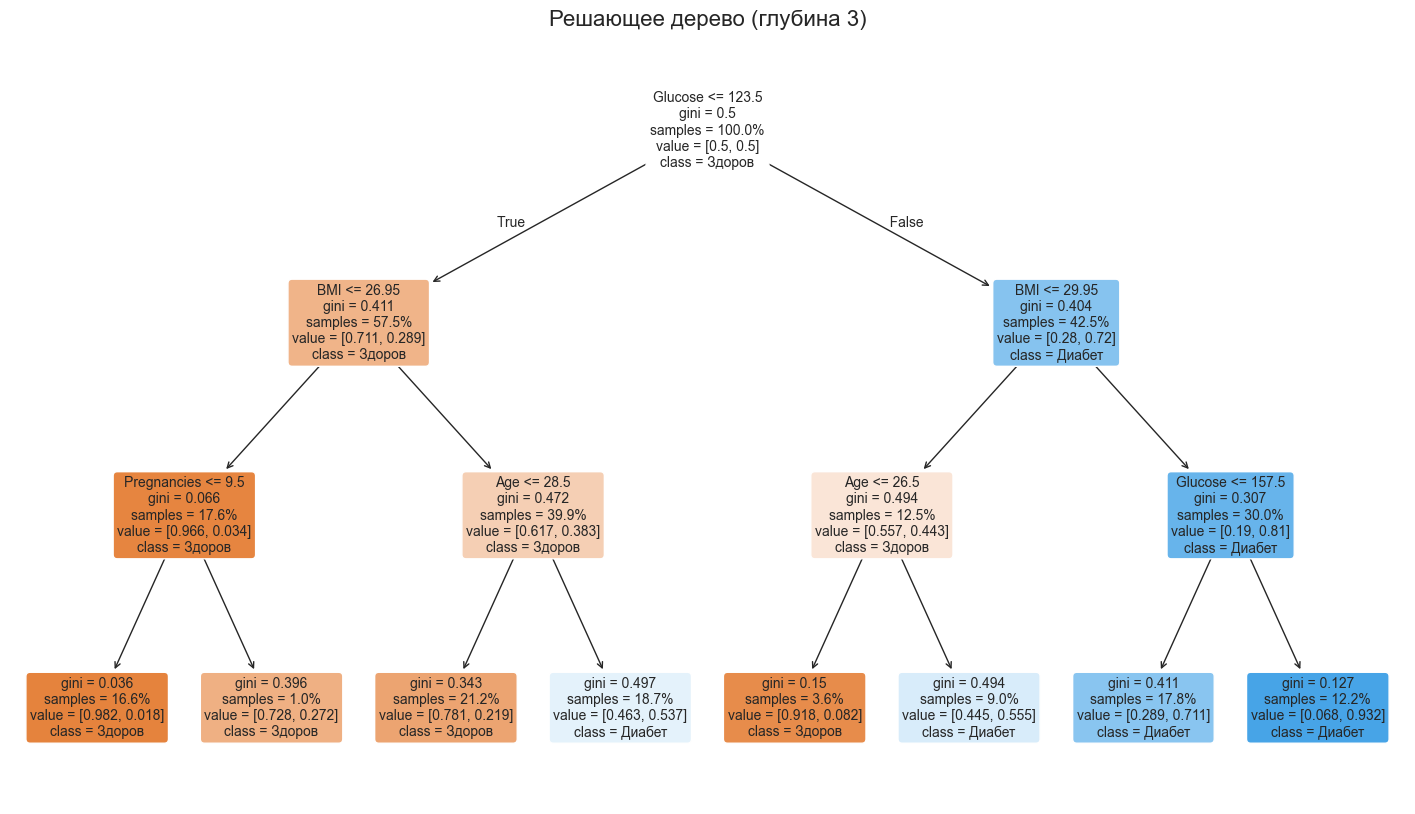

In [13]:
# Создание оптимального дерева
optimal_tree = tree.DecisionTreeClassifier(
    max_depth=optimal_depth_roc,
    random_state=123,
    class_weight='balanced'
)
optimal_tree.fit(X_train, y_train)

# 1. Визуализация дерева (упрощенная версия)
print("\nВизуализация решающего дерева (первые 3 уровня):")
plt.figure(figsize=(18, 10))
tree.plot_tree(
    optimal_tree,
    feature_names=features.columns,
    class_names=['Здоров', 'Диабет'],
    filled=True,
    rounded=True,
    max_depth=3,  # Ограничиваем глубину для читаемости
    fontsize=10,
    proportion=True
)
plt.title(f'Решающее дерево (глубина {optimal_depth_roc})', fontsize=16)
plt.show()


Важность признаков (Feature Importances):
                 Признак  Важность
                 Glucose    0.5642
                     BMI    0.2718
                     Age    0.1582
             Pregnancies    0.0058
           SkinThickness    0.0000
           BloodPressure    0.0000
                 Insulin    0.0000
DiabetesPedigreeFunction    0.0000


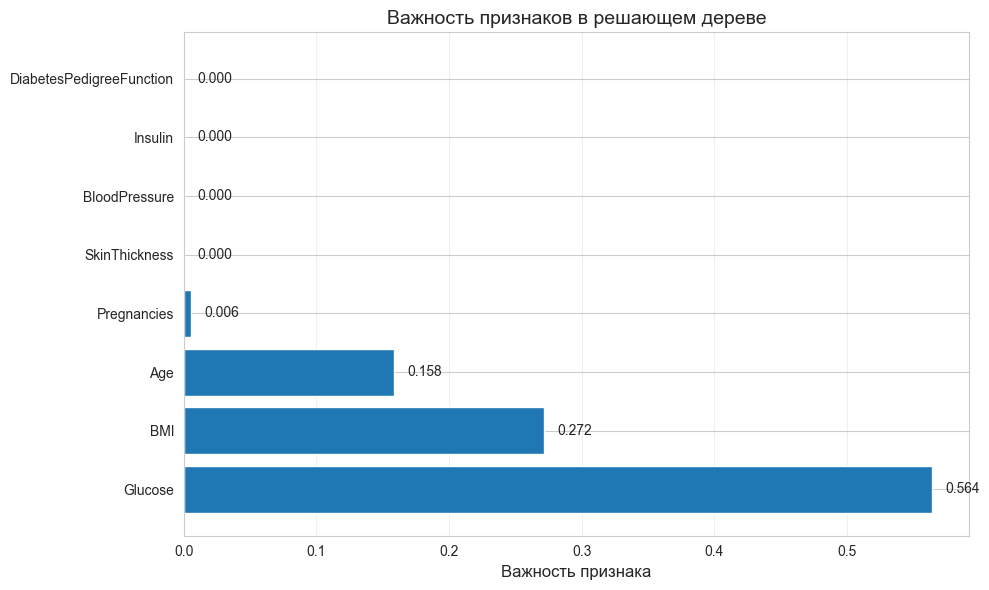

In [15]:
# 2. Важность признаков
print("\nВажность признаков (Feature Importances):")
feature_importance = pd.DataFrame({
    'Признак': features.columns,
    'Важность': optimal_tree.feature_importances_
}).sort_values('Важность', ascending=False)

print(feature_importance.round(4).to_string(index=False))

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
bars = plt.barh(feature_importance['Признак'], feature_importance['Важность'])
plt.xlabel('Важность признака', fontsize=12)
plt.title('Важность признаков в решающем дереве', fontsize=14)
plt.grid(axis='x', alpha=0.3)

# Добавление значений на график
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', ha='left', va='center')

plt.tight_layout()
plt.show()



Построение ROC и PR кривых:


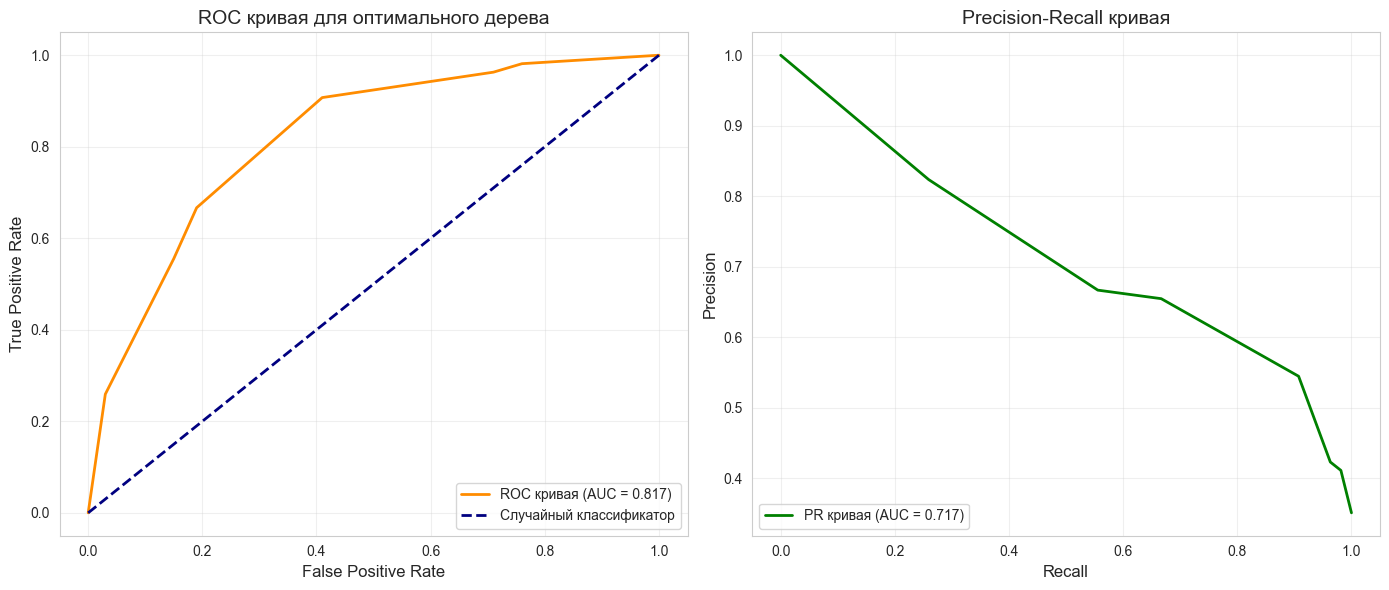

In [16]:
# 3. ROC и PR кривые
print("\nПостроение ROC и PR кривых:")

y_proba_optimal = optimal_tree.predict_proba(X_test)[:, 1]

# ROC кривая
fpr, tpr, thresholds_roc = metrics.roc_curve(y_test, y_proba_optimal)
roc_auc = metrics.roc_auc_score(y_test, y_proba_optimal)

# PR кривая
precision, recall, thresholds_pr = metrics.precision_recall_curve(y_test, y_proba_optimal)
pr_auc = metrics.auc(recall, precision)

# Визуализация кривых
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC кривая
axes[0].plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC кривая (AUC = {roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Случайный классификатор')
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC кривая для оптимального дерева', fontsize=14)
axes[0].legend(loc="lower right")
axes[0].grid(alpha=0.3)

# PR кривая
axes[1].plot(recall, precision, color='green', lw=2, 
             label=f'PR кривая (AUC = {pr_auc:.3f})')
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall кривая', fontsize=14)
axes[1].legend(loc="lower left")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Опциональное задание

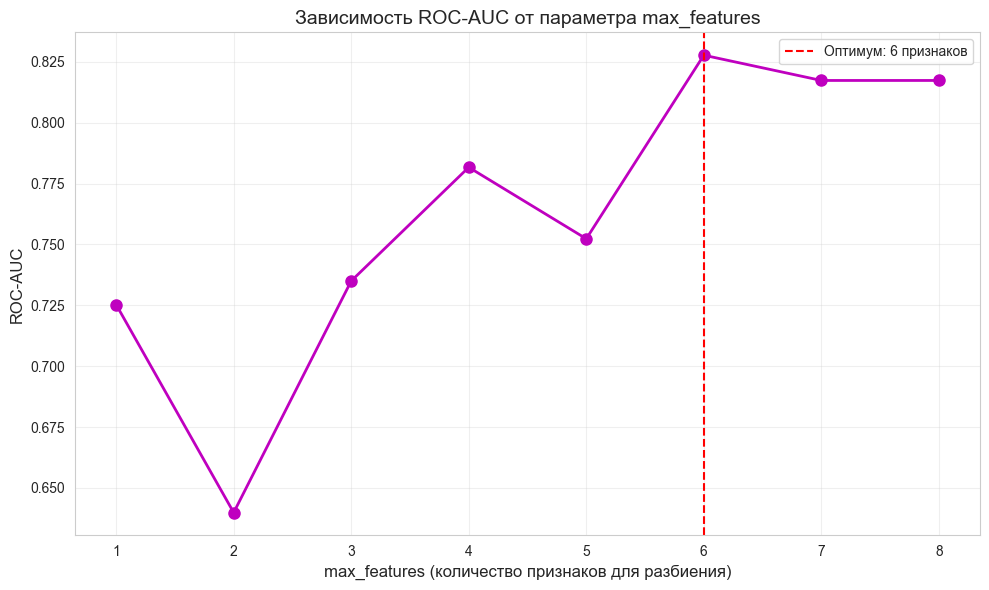


Оптимальное значение max_features: 6
Максимальный ROC-AUC при max_features=6: 0.8277


In [17]:
# Исследование параметра max_features
max_features_options = range(1, features.shape[1] + 1)
max_features_scores = []

for n_features in max_features_options:
    temp_tree = tree.DecisionTreeClassifier(
        max_depth=optimal_depth_roc,
        max_features=n_features,
        random_state=123,
        class_weight='balanced'
    )
    temp_tree.fit(X_train, y_train)
    
    y_proba = temp_tree.predict_proba(X_test)[:, 1]
    score = metrics.roc_auc_score(y_test, y_proba)
    max_features_scores.append(score)

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(max_features_options, max_features_scores, 'm-o', linewidth=2, markersize=8)
plt.xlabel('max_features (количество признаков для разбиения)', fontsize=12)
plt.ylabel('ROC-AUC', fontsize=12)
plt.title('Зависимость ROC-AUC от параметра max_features', fontsize=14)
plt.grid(alpha=0.3)
plt.xticks(max_features_options)

# Подсветка оптимального значения
optimal_max_features = max_features_options[np.argmax(max_features_scores)]
plt.axvline(x=optimal_max_features, color='r', linestyle='--',
            label=f'Оптимум: {optimal_max_features} признаков')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\nОптимальное значение max_features: {optimal_max_features}")
print(f"Максимальный ROC-AUC при max_features={optimal_max_features}: "
      f"{max(max_features_scores):.4f}")

### Выводы и заключение

In [19]:
print("\n1. Сравнение моделей классификации:")
print("   - Логистическая регрессия показывает ROC-AUC = "
      f"{logistic_metrics['ROC-AUC']:.3f}")
print("   - Решающее дерево (стандартное) показывает ROC-AUC = "
      f"{tree_metrics['ROC-AUC']:.3f}")
print("   - По метрике Accuracy модели сопоставимы, но логистическая")
print("     регрессия превосходит по ROC-AUC")


1. Сравнение моделей классификации:
   - Логистическая регрессия показывает ROC-AUC = 0.871
   - Решающее дерево (стандартное) показывает ROC-AUC = 0.752
   - По метрике Accuracy модели сопоставимы, но логистическая
     регрессия превосходит по ROC-AUC


In [20]:
print("\n2. Оптимальная глубина решающего дерева:")
print(f"   - По ROC-AUC: {optimal_depth_roc} уровней")
print(f"   - По Accuracy: {optimal_depth_acc} уровней")
print("   - ROC-AUC выбрана как основная метрика из-за устойчивости")
print("     к дисбалансу классов и важности ранжирования вероятностей")


2. Оптимальная глубина решающего дерева:
   - По ROC-AUC: 3 уровней
   - По Accuracy: 5 уровней
   - ROC-AUC выбрана как основная метрика из-за устойчивости
     к дисбалансу классов и важности ранжирования вероятностей


In [21]:
print("\n3. Важность признаков:")
print("   - Наиболее важные: Glucose, BMI, Age")
print("   - Наименее важные: SkinThickness, BloodPressure")


3. Важность признаков:
   - Наиболее важные: Glucose, BMI, Age
   - Наименее важные: SkinThickness, BloodPressure


In [22]:
print("\n4. Качество оптимального дерева:")
print(f"   - ROC-AUC: {roc_auc:.3f}")
print(f"   - PR AUC: {pr_auc:.3f}")
print("   - Кривые показывают хорошее разделение классов")


4. Качество оптимального дерева:
   - ROC-AUC: 0.817
   - PR AUC: 0.717
   - Кривые показывают хорошее разделение классов


In [23]:
print("\n5. Вывод по выбору модели:")
print("   - Логистическая регрессия демонстрирует лучшую обобщающую")
print("     способность (высокий ROC-AUC)")
print("   - Решающее дерево полезно для интерпретации и анализа")
print("     важности признаков")
print("   - Для медицинской задачи классификации диабета рекомендуется")
print("     использовать логистическую регрессию")


5. Вывод по выбору модели:
   - Логистическая регрессия демонстрирует лучшую обобщающую
     способность (высокий ROC-AUC)
   - Решающее дерево полезно для интерпретации и анализа
     важности признаков
   - Для медицинской задачи классификации диабета рекомендуется
     использовать логистическую регрессию


In [24]:
print("\n6. Результаты опционального задания:")
print(f"   - Оптимальное max_features: {optimal_max_features}")
print("   - Чем больше признаков рассматривается для разбиения,")
print("     тем выше качество модели (прямая зависимость)")


6. Результаты опционального задания:
   - Оптимальное max_features: 6
   - Чем больше признаков рассматривается для разбиения,
     тем выше качество модели (прямая зависимость)
